(gp_prediction)=
# GP for prediction

As mentioned in our [introduction](gp_theory), GPs can be used for predictions using additive or multiplicative combinations of covariance functions. This is a way to decompose an energy consumption curve into long-term trends and periodical components.

[PyMC's GP implementations](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/Gaussian_Processes.html) makes this decomposition convenient. This tutorial is largely inspired from [this example](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-MaunaLoa.html) of GP for the prediction of CO$_2$ at Mauna Loa, a common machine learning dataset example.

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import arviz as az
import pymc as pm

We will be building a GP to predict the electricity consumption of [building 1298](building1298) from the [Great Energy Predictor](https://www.kaggle.com/c/ashrae-energy-prediction) Kaggle competition.

In the following block, we are loading the data, filtering out outliers, and saving the meter data `m0` into a normalized variable `y`. Then we select one month of readings as training data, and the next month as test prediction data.

Text(0, 0.5, 'y')

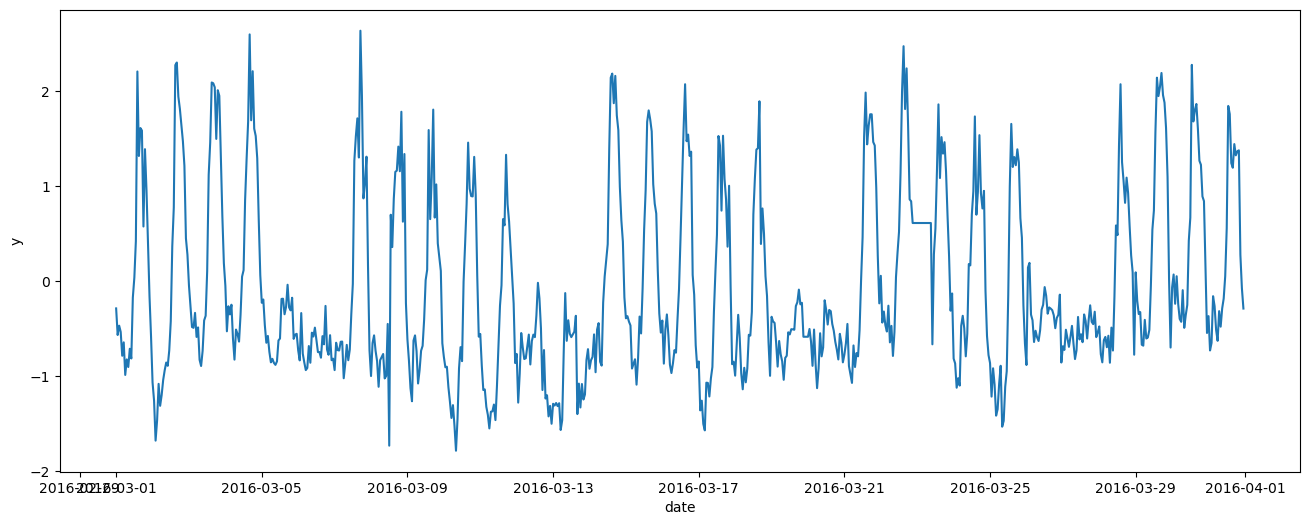

In [28]:
df = pd.read_csv("data/building_1298.csv", index_col=0, parse_dates=True)

df["weekday"] = df.index.weekday
df["hour"] = df.index.hour
df["t"] = np.arange(len(df))
df['hour_of_the_week'] = df.index.dayofweek * 24 + (df.index.hour + 1)

df.drop(df[df.m0 < 300].index, inplace=True)
df = df.assign(y= (df["m0"] - np.mean(df["m0"])) / np.std(df["m0"]))

df_train = df.loc['2016-03-01':'2016-03-31']
df_test = df.loc['2016-04-01':'2016-04-30']
df_all = pd.concat([df_train, df_test])

_, ax = plt.subplots(figsize=(16, 6))
ax.plot(df_train.index, df_train['y'])
ax.set_xlabel("date")
ax.set_ylabel("y")

We can clearly see a weekly pattern: five days of high electricity consumption, followed by two days of lower consumption. There is also a long-term trend: the baseline is not constant.

Before building our GP, it is worth checking whether the electricity consumption seems impacted by the outdoor air temperature:

Text(0, 0.5, 'y')

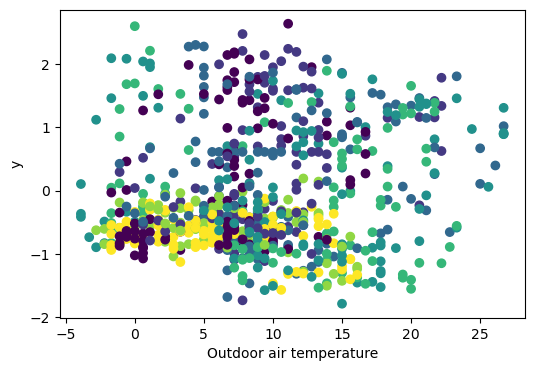

In [29]:
_, ax = plt.subplots(figsize=(6, 4))
ax.scatter(df_train['air_temperature'], df_train['y'], c = df_train["weekday"])
ax.set_xlabel("Outdoor air temperature")
ax.set_ylabel("y")

There doesn't seem to be an impactful relationship between our variable `y` and the temperature: we can rule it out.

We now build out GP, mostly inspired from [the Mauna Loa example](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-MaunaLoa.html), as the addition of two components:

* A function of the "hour of the week" will model the weekly repetitive pattern, with a Matern covariance.
* A long-term trend with the time "t" as input, with an ExpQuad covariance.

PyMC's GPs can operate with multiple inputs, and we are using this feature with two variables. We could also have added a temperature-dependent component, if the data had suggested that it was relevant.

In [30]:
Y = df_train["y"].values
X = df_train[["t", "hour_of_the_week"]].values

with pm.Model() as model:

    # First, a GP is instantiated with a mean function and a covariance function

    # Function of the "hour of the week"
    η_how = pm.Gamma("η_how", alpha=8, beta=5)
    ℓ_how = pm.Gamma("ℓ_how ", alpha=1, beta=1)
    cov_how = η_how**2 * pm.gp.cov.Matern52(input_dim=2, ls=ℓ_how, active_dims=[1])
    gp_how = pm.gp.Marginal(cov_func=cov_how)

    # Long term trend
    η_trend = pm.HalfCauchy("η_trend", beta=0.2)
    ℓ_trend = pm.Gamma("ℓ_trend", alpha=4, beta=0.1)
    cov_trend = η_trend**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ℓ_trend, active_dims=[0])
    gp_trend = pm.gp.Marginal(cov_func=cov_trend)

    # Then, GP objects can be added together, allowing for function characteristics to be carefully modeled and separated.
    gp = gp_how + gp_trend

    # Noise model
    η_noise = pm.HalfNormal("η_noise", sigma=0.5, initval=0.05)
    ℓ_noise = pm.Gamma("ℓ_noise", alpha=2, beta=4)
    σ = pm.HalfNormal("σ", sigma=0.25, initval=0.05)
    cov_noise = η_noise**2 * pm.gp.cov.Matern32(input_dim=2, ls=ℓ_noise, active_dims=[0]) + pm.gp.cov.WhiteNoise(σ)

    # Finally, one of prior, marginal_likelihood or conditional methods is called on the GP object
    # to actually construct the PyMC random variable that represents the function prior.
    # Since the normal noise model and the GP are conjugates, we use `Marginal` with the `.marginal_likelihood` method
    y_ = gp.marginal_likelihood("y", X, Y, sigma=cov_noise)

    # This line calls an optimizer to find the MAP of the kernel parameters
    mp = pm.find_MAP(include_transformed=True)
    
    # PRIOR PREDICTIVE SAMPLING
    # Calling the prior method will create a PyMC random variable that represents the latent function f(x) = f
    # f = gp.prior("f", X)
    # The conditional method creates the conditional, or predictive, distribution over the latent function at arbitrary input points
    # f_star = gp.conditional("f_star", X_star)

    # idata = pm.sample(1000)

Output()

So far we have given priors to the hyperparameters (parameters of the covariance functions), and estimated their MAP. The last few lines of the previous block show how to perform prior predictions, i.e. predicting the values of the GP on test points `X_star`, without conditioning on the training data.

Predictions conditioned on training data can now be done as follows, either with the full GP model or with any of its components.

In [31]:
Xnew = df_all[["t", "hour_of_the_week"]].values

with pm.Model() as model:

    # Prédiction de chaque gp
    mu_period, var_period = gp_how.predict(Xnew, point=mp, given={"gp": gp, "X": X, "y": Y, "sigma": cov_noise}, diag=True)
    #mu_medium, var_medium = gp_medium.predict(Xnew, point=mp, given={"gp": gp, "X": X, "y": Y, "noise": cov_noise}, diag=True)
    mu_trend, var_trend = gp_trend.predict(Xnew, point=mp, given={"gp": gp, "X": X, "y": Y, "sigma": cov_noise}, diag=True)

    # Total
    mu, var = gp.predict(Xnew, point=mp, diag=True)

Text(0, 0.5, 'm0')

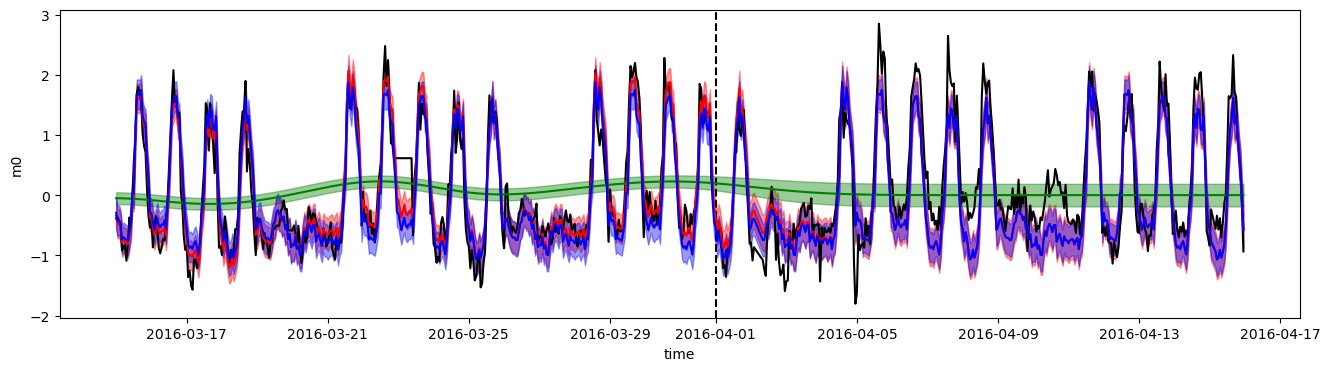

In [32]:
fit = pd.DataFrame(
    {"t": df_all["t"], "hour_of_the_week": df_all["hour_of_the_week"], "y_obs": df_all["y"], "temp": df_all['air_temperature'],
     "mu_total": mu, "sd_total": np.sqrt(var), 
     "mu_period": mu_period, "sd_period": np.sqrt(var_period),
    "mu_trend": mu_trend, "sd_trend": np.sqrt(var_trend)},
    index=df_all.index,
)

# A plot of the dependent variable vs. each of the explanatory variables
dfplot = fit.loc['2016-03-15':'2016-04-15']
_, ax = plt.subplots(figsize=(16, 4))
ax.plot(dfplot.index, dfplot['y_obs'], color="black")
ax.vlines(pd.Timestamp('2016-04-01'), 0, 1, transform=ax.get_xaxis_transform(), color='k', linestyles='dashed')
ax.plot(dfplot.index, dfplot['mu_total'], color='red')
ax.fill_between(dfplot.index, dfplot['mu_total'] - 2*dfplot['sd_total'], dfplot['mu_total'] + 2*dfplot['sd_total'], color='red', alpha=0.4)
ax.plot(dfplot.index, dfplot['mu_trend'], color='green')
ax.fill_between(dfplot.index, dfplot['mu_trend'] - 2*dfplot['sd_trend'], dfplot['mu_trend'] + 2*dfplot['sd_trend'], color='green', alpha=0.4)
ax.plot(dfplot.index, dfplot['mu_period'], color='blue')
ax.fill_between(dfplot.index, dfplot['mu_period'] - 2*dfplot['sd_period'], dfplot['mu_period'] + 2*dfplot['sd_period'], color='blue', alpha=0.4)
ax.set_xlabel("time")
ax.set_ylabel("m0")

The dotted line shows the separation between the training and test periods.

* The long-term trend component, in green, quickly falls to a zero mean after the start of the test period: this is expected behavior.
* The second component in blue, based on the hour of the week, has a repetitive weekly behavior.
* The sum of these two components, in red, matches the training data well, but is less accurate in the test prediction because of the trend component falling to zero. Its uncertainty is however increased to account for this unknown trend.